In [ ]:
from scipy.stats.stats import pearsonr
import numpy as np
import pandas as pd 
#%matplotlib inline
#import matplotlib.pyplot as plt
#import seaborn as sns

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [ ]:
df = pd.read_csv('/Users/desert/desert_workspace/desert_data/clean_data.csv')
df = df.drop('Unnamed: 0', axis=1)
df.head()

In [ ]:

def order(frame,var):
    varlist =[w for w in frame.columns if w not in var]
    frame = frame[var+varlist]
    return frame 

def covariance(variable_1, variable_2, bias=0):
    observations = float(len(variable_1))
    return np.sum((variable_1 - np.mean(variable_1)) * (variable_2 - np.mean(variable_2)))/(observations-min(bias,1))

def standardize(variable):
    return (variable - np.mean(variable)) / np.std(variable)

def correlation(var1,var2,bias=0):
    return covariance(standardize(var1), standardize(var2),bias)

In [ ]:
df.columns.tolist()
grouped = df.groupby('high_food_des_prev')
food_des = grouped.get_group(1)
non_food_des = grouped.get_group(0)

In [ ]:
df.info(verbose=True)

https://chhs.data.ca.gov/Demographics/Medical-Service-Study-Areas-2010/s6uk-kn8j

In [ ]:
mssa = pd.read_csv('/Users/desert/downloads/Medical_Service_Study_Areas__2010.csv')
mssa = mssa[['CNTY_FIPS','COUNTY']]#,'UNIT_COUNT','MSSA_ID','DEFINITION','POP']]
mssa.columns = [x.title() for x in mssa.columns]
mssa = mssa.drop_duplicates()
df = pd.merge(df,mssa,how='inner', on='County')


In [ ]:
from bokeh.models import HoverTool
#from bokeh.palettes import Viridis6
from bokeh.plotting import figure, show, ColumnDataSource, output_file
import bokeh.sampledata
from bokeh.sampledata.us_counties import data as counties
from bokeh.sampledata.unemployment import data as unemployment
from bokeh.sampledata.us_states import data as states

#bokeh.sampledata.download()


In [ ]:
from bokeh.io import output_notebook
output_notebook()

In [ ]:
counties = {
    code: county for code, county in counties.items() if county["state"] == "ca"
}

colors = ["#F1EEF6", "#D4B9DA", "#C994C7", "#DF65B0", "#DD1C77", "#980043"]

county_xs = [county["lons"] for county in counties.values()]
county_ys = [county["lats"] for county in counties.values()]

county_names = [county['name'] for county in counties.values()]
county_rates = [unemployment[county_id] for county_id in counties]

county_colors = [colors[int(rate/6)] for rate in county_rates]

data=dict(
    x=county_xs,
    y=county_ys,
    color=county_colors,
    name=county_names,
    rate=county_rates,
)


data = pd.DataFrame(data)
data.head()
data.rename(columns={'name':'County'}, inplace=True)
c= pd.merge(data, df[['n_food_des','County','LILATracts_1And10']], how='left', on='County')
c = c.fillna(0)
c.rename(columns={'County':'name', 'rate':'unem', 'n_food_des' : 'rate'}, inplace=True)

def quantile(col, q=[0,0.25,0.5,0.75,1]):
    colors = ["#F1EEF6", "#D4B9DA", "#C994C7", "#DF65B0", "#DD1C77", "#980043"]
    q0,q1,q2,q3,q4 = col.quantile(q)
    vals = [val for val in col]
    rate = []
    for elem in vals:
        if elem == q4:
            rate.append(colors[5])
        if elem < q4 and elem >= q3:
            rate.append(colors[4])
        if elem < q3 and elem >= q2:
            rate.append(colors[3])
        if elem < q2 and elem >= q1:
            rate.append(colors[2])
        if elem < q1:
            rate.append(colors[0])
    return rate
    

c['prev'] = quantile(c['rate'])
c.head()

In [ ]:
c[c['name'] == 'Fresno']

In [ ]:
source = ColumnDataSource(data=c)

TOOLS="pan,wheel_zoom,box_zoom,reset,hover,save,resize"
p = figure(title="CA Coutnies: Food Deserts counts 2010", toolbar_location="left", tools = TOOLS)


p.patches('x', 'y', source=source,
          fill_color='prev', fill_alpha=0.7,
          line_color="#884444", line_width=2, line_alpha=0.3)

hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("Name", "@name"),
    ("Food Deserts)", "@rate"),
    ("(Long, Lat)", "($x, $y)"),
]
output_notebook()
show(p)

In [ ]:
c= pd.merge(data, df[['des_percent','County','LILATracts_1And10']], how='left', on='County')
c = c.fillna(0)
c.rename(columns={'County':'name', 'rate':'unem', 'des_percent' : 'rate'}, inplace=True)
c['prev'] = quantile(c['rate'])

source = ColumnDataSource(data=c)

TOOLS="pan,wheel_zoom,box_zoom,reset,hover,save,resize"

p = figure(title="CA Number Food Deserts / Total Counties: 2010", toolbar_location="left", tools = TOOLS)


p.patches('x', 'y', source=source,
          fill_color='prev', fill_alpha=0.7,
          line_color="#884444", line_width=2, line_alpha=0.3)

hover.point_policy = "follow_mouse"
hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("Name", "@name"),
    ("Food Deserts)", "@rate"),
    ("(Long, Lat)", "($x, $y)"),
]
output_notebook()
show(p)

http://www.chcf.org/oscn/data

In [ ]:
op = pd.read_excel('/Users/desert/desert_workspace/desert_data/OpioidSafetyData/Prescription_Data_byCounty_2010-13_OpioidSafetyCoalitions_run041216.xlsx', sheet=1)
op.head()

In [ ]:
op=op[['County','2010 \n# of opioid prescriptions per 1000 residents per year \n(excl bupe)']]
op.columns = ['County', 'opiods_rx_1000']
op.head()

In [ ]:
mask = op['County'].isin(df['County'])
op = op[mask]
df = pd.merge(df,op,how='inner',on='County')
df.head()

In [ ]:
c= pd.merge(data, df[['opiods_rx_1000','County','LILATracts_1And10']], how='left', on='County')
c = c.fillna(0)
c.rename(columns={'County':'name', 'rate':'unem', 'opiods_rx_1000' : 'rate'}, inplace=True)
c['prev'] = quantile(c['rate'])

source = ColumnDataSource(data=c)

TOOLS="pan,wheel_zoom,box_zoom,reset,hover,save,resize"

p = figure(title="CA Opiod Rx's per 1000 Residents By County: 2010", toolbar_location="left", tools = TOOLS)


p.patches('x', 'y', source=source,
          fill_color='prev', fill_alpha=0.7,
          line_color="#884444", line_width=2, line_alpha=0.3)

hover.point_policy = "follow_mouse"
hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("Name", "@name"),
    ("Opioid rx per 1000 residents per yr)", "@rate"),
    ("(Long, Lat)", "($x, $y)"),
]
output_notebook()
show(p)

In [ ]:
df.tail(15)#1254.24
op[op['County'] == 'Siskiyou']

In [ ]:
inf = pd.read_csv('/Users/workspace/food_desert_data/Infectious_Disease_Cases_by_County__Year__and_Sex__2001-2014.csv')
inf = inf[(inf['Year'] == 2010) & (inf['County']!='California')]
inf = inf[inf['Sex'] == 'Total']
grouped=inf.groupby(['County','Disease']).agg(np.mean)[['Count', 'Rate']].reset_index()
inf_counts=grouped.pivot(index='County', columns='Disease', values='Count').reset_index()
inf_rates=grouped.pivot(index='County', columns='Disease', values='Rate').reset_index()
drop = inf_rates.columns.tolist()[1:]

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:

keep = [col for col in df.columns.tolist() if col not in drop]

corrmat = df[keep].corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 12))

# Draw the heatmap using seaborn, and add a title to the plot
sns.heatmap(corrmat, vmax=.8, square=True)
ax.set_title('CA Food Desert Data Correlations')
f.tight_layout()

In [ ]:
df[['County','POP2010','des_percent', 'num_tracts','n_food_des']]
affected = (df['POP2010'] * df['des_percent'])
df['pop2010_in_des'] = affected
df['pop2010_in_des'] = df['pop2010_in_des'].astype(int)
df[['County','POP2010','pop2010_in_des','des_percent', 'num_tracts','n_food_des']]
#df[keep].columns.tolist()

In [ ]:
pops=pd.read_excel('/Users/workspace/PycharmProjects/desert/desert_data/food_desert.xlsx',sheetname=2)
cols = pops.columns.tolist()


In [ ]:
subset = ['CensusTract','State','County','POP2010','Rural','Urban','LILATracts_1And10']
pops = pops[pops['State']=='CA']
pops=pops[subset]
grouped = pops[['County','POP2010','Rural','Urban','LILATracts_1And10']].groupby(['County','LILATracts_1And10']).sum()
grouped = grouped.reset_index()
deserts = grouped[grouped['LILATracts_1And10']==1]
deserts=deserts[['County','POP2010']]
deserts.columns = ['County','pop2010_in_des']
deserts.head()

In [ ]:
df.columns.tolist()
df = df.drop('pop2010_in_des', axis=1)
df = pd.merge(df,deserts,how='left', on='County')
df.head()

In [ ]:
def order(frame,var):
    varlist =[w for w in frame.columns if w not in var]
    frame = frame[var+varlist]
    return frame 

df=order(df,['County','pop2010_in_des'])
df.head()

In [ ]:
df['pop2010_in_des'] = df['pop2010_in_des'].fillna(0)
df.head()

In [ ]:
c= pd.merge(data, df[['pop2010_in_des','County','LILATracts_1And10']], how='left', on='County')
c = c.fillna(0)
c.rename(columns={'County':'name', 'rate':'unem', 'pop2010_in_des' : 'rate'}, inplace=True)
c['prev'] = quantile(c['rate'])

source = ColumnDataSource(data=c)

TOOLS="pan,wheel_zoom,box_zoom,reset,hover,save,resize"

p = figure(title="Number of Residents affected by Food Desert By County: 2010", toolbar_location="left", tools = TOOLS)


p.patches('x', 'y', source=source,
          fill_color='prev', fill_alpha=0.7,
          line_color="#884444", line_width=2, line_alpha=0.3)

hover.point_policy = "follow_mouse"
hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("Name", "@name"),
    ("number of residents living in food desert)", "@rate"),
    ("(Long, Lat)", "($x, $y)"),
]
output_notebook()
show(p)

In [ ]:
keep = [col for col in df.columns.tolist() if col not in drop]

corrmat = df[keep].corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 12))

# Draw the heatmap using seaborn, and add a title to the plot
sns.heatmap(corrmat, vmax=.8, square=True)
ax.set_title('CA Food Desert Data Correlations')
f.tight_layout()

In [ ]:
perc_in_des = df['pop2010_in_des'] / df['POP2010'] 
df['percent_food_desert'] = perc_in_des
df=order(df,['County','percent_food_desert'])
keep = [col for col in df.columns.tolist() if col not in drop]

corrmat = df[keep].corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 12))

# Draw the heatmap using seaborn, and add a title to the plot
sns.heatmap(corrmat, vmax=.8, square=True)
ax.set_title('CA Food Desert Data Correlations')
f.tight_layout()

In [ ]:
sns.distplot(df['percent_food_desert'])

In [ ]:
slim = df[['percent_food_desert','cnty_obesity_pct_adj','cnty_dm_pct_adj','cnty_inactive_pct_adj','POP2010','OHU2010','NUMGQTRS','HUNVFlag','Adolescent_births','ABR','p_hs_edatt','Rural','Urban','PC_PHYS_R','DENTIST_R','PSYCH_R','PCT_HSPNC',
 'PCT_WHITE',
 'PCT_BLACK',
 'PCT_ASIAN',
 'PCT_AMIND_ESK',
 'PCT_ISLANDER',
 'PCT_MULTI',
 'PCT_OTHER',
 'PCT_65OVER',
 'PCT_18_64',
 'PCT_UNDR18',
 'PCT_UNDER5','unemployment_rate',
 'n_hospitals','opiods_rx_1000']]
slim
corrmat = slim.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 12))

# Draw the heatmap using seaborn, and add a title to the plot
sns.heatmap(corrmat, vmax=.8, square=True)
ax.set_title('CA Food Desert Data Correlations')
f.tight_layout()

In [ ]:
des = df[df['percent_food_desert'] >= .1]
not_des = df[df['percent_food_desert'] < .1]
des_mean=des['opiods_rx_1000'].mean()
not_des_mean=not_des['opiods_rx_1000'].mean()

In [ ]:
print "Food desert counties Opioid Rx mean", des_mean
print "NON-food desert counties Opioid Rx mean", not_des_mean

print "Effect size: ", abs(des_mean - not_des_mean)

In [ ]:
# sns.distplot(des['opiods_rx_1000'])
# sns.distplot(not_des['opiods_rx_1000'])
plt.show()
df['y'] = df['percent_food_desert'] >= .1
df['y'] =df['y'].astype(int)
ax = sns.boxplot(x="y", y="opiods_rx_1000", data=df)


In [ ]:
groupby_des = df.groupby('y')
for cat, value in groupby_des['opiods_rx_1000']:
    print((cat, value.mean()))

In [ ]:
import scipy.stats as stats
groupby_des.mean()
stats.ttest_1samp(df['opiods_rx_1000'], 0)  

With a p-value of 3^-27 we can claim that the population mean for the opioid prescriptions in CA is not 0.  

We have seen above that the mean number of opioid prescriptions per 1000 citizens in the food desert and non_food_desert counties were different. To test if this is significant, we do a 2-sample t-test with scipy.stats.ttest_ind():

In [ ]:
des_rx = des['opiods_rx_1000']
non_des_rx = not_des['opiods_rx_1000']
stats.ttest_ind(des_rx, non_des_rx)  

with a p value < than 0.05, we conclude there is a statistically significant difference in opiod prescriptions between counties with a high and low prevelances of food deserts

Bayesian Approach
---

In [116]:
bayes= df[['POP2010','cnty_dm_pct','y']].copy()
bayes.groupby('y').mean()
bayes['cnty_dm_pct'] = bayes['cnty_dm_pct'] * .01
bayes['dm'] = bayes['cnty_dm_pct'] * bayes['POP2010']
bayes['dm'] =bayes['dm'].astype(int) 
bayes
sums=bayes.groupby('y').sum()
sums['POP2010'].ix[0]

non_des_pop = sums['POP2010'].ix[0]
non_des_dm = sums['dm'].ix[0]
des_pop =  sums['POP2010'].ix[1]
des_dm  = sums['dm'].ix[0]
sums

# The parameters are the bounds of the Uniform.
p = pm.Uniform('p', lower=0, upper=1)

# set constants
p_true = 0.05  # remember, this is unknown.
N = 1500

In [117]:
data_A = np.r_[[0] * (non_des_pop - non_des_dm), [1] * non_des_dm]
data_B = np.r_[[0] * (des_pop - des_dm), [1] * des_dm]
data_A

array([0, 0, 0, ..., 1, 1, 1])

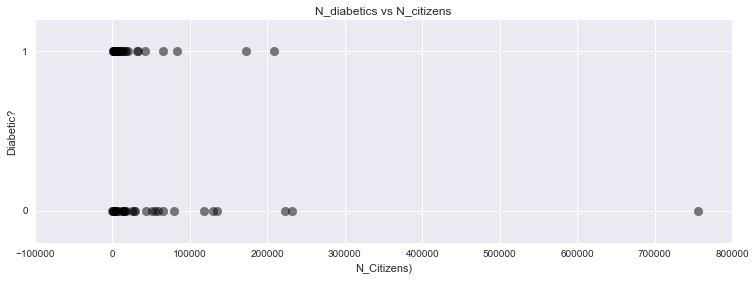

In [127]:
#bayes.groupby('y').sum()
# bayes.groupby('y').mean()
# obs = pm.Bernoulli('obs', p, value=data_B, observed=True)
# mcmc = pm.MCMC([p,obs])
# mcmc.sample(2000,1000)
bayes


plt.scatter(bayes['dm'], bayes['y'], s=75, color="k",
            alpha=0.5)
plt.yticks([0, 1])
plt.ylabel("Diabetic?")
plt.xlabel("N_Citizens)")
plt.title("N_diabetics vs N_citizens")

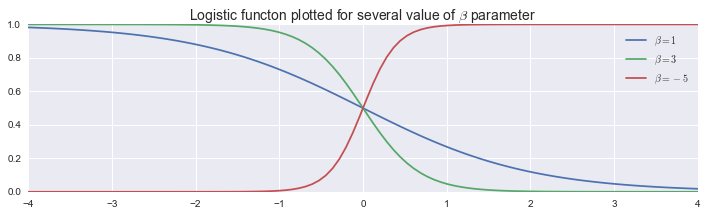

In [139]:

figsize(12, 3)


def logistic(x, beta):
    return 1.0 / (1.0 + np.exp(beta * x))

x = np.linspace(-4, 4, 100)
plt.plot(x, logistic(x, 1), label=r"$\beta = 1$")
plt.plot(x, logistic(x, 3), label=r"$\beta = 3$")
plt.plot(x, logistic(x, -5), label=r"$\beta = -5$")
plt.title("Logistic functon plotted for several value of $\\beta$ parameter", fontsize=14)
plt.legend();

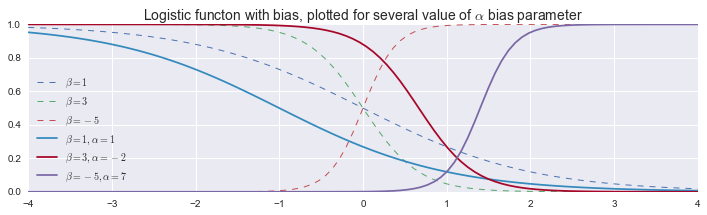

In [140]:

def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

x = np.linspace(-4, 4, 100)

plt.plot(x, logistic(x, 1), label=r"$\beta = 1$", ls="--", lw=1)
plt.plot(x, logistic(x, 3), label=r"$\beta = 3$", ls="--", lw=1)
plt.plot(x, logistic(x, -5), label=r"$\beta = -5$", ls="--", lw=1)

plt.plot(x, logistic(x, 1, 1), label=r"$\beta = 1, \alpha = 1$",
         color="#348ABD")
plt.plot(x, logistic(x, 3, -2), label=r"$\beta = 3, \alpha = -2$",
         color="#A60628")
plt.plot(x, logistic(x, -5, 7), label=r"$\beta = -5, \alpha = 7$",
         color="#7A68A6")

plt.title("Logistic functon with bias, plotted for several value of $\\alpha$ bias parameter", fontsize=14)
plt.legend(loc="lower left");

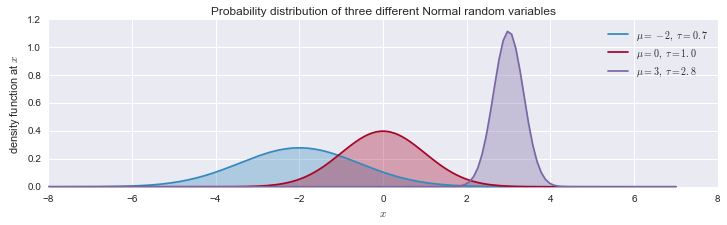

In [141]:
import scipy.stats as stats

nor = stats.norm
x = np.linspace(-8, 7, 150)
mu = (-2, 0, 3)
tau = (.7, 1, 2.8)
colors = ["#348ABD", "#A60628", "#7A68A6"]
parameters = zip(mu, tau, colors)

for _mu, _tau, _color in parameters:
    plt.plot(x, nor.pdf(x, _mu, scale=1. / _tau),
             label="$\mu = %d,\;\\tau = %.1f$" % (_mu, _tau), color=_color)
    plt.fill_between(x, nor.pdf(x, _mu, scale=1. / _tau), color=_color,
                     alpha=.33)

plt.legend(loc="upper right")
plt.xlabel("$x$")
plt.ylabel("density function at $x$")
plt.title("Probability distribution of three different Normal random \
variables");

In [143]:
temperature = bayes['dm'].values
D = bayes['y'].values  # defect or not?

# notice the`value` here. We explain why below.
beta = pm.Normal("beta", 0, 0.001, value=0)
alpha = pm.Normal("alpha", 0, 0.001, value=0)


@pm.deterministic
def p(t=temperature, alpha=alpha, beta=beta):
    return 1.0 / (1. + np.exp(beta * t + alpha))

In [144]:
p.value


array([ 0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,
        0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,
        0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,
        0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,
        0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,
        0.5,  0.5,  0.5])

In [145]:
# connect the probabilities in `p` with our observations through a
# Bernoulli random variable.
observed = pm.Bernoulli("bernoulli_obs", p, value=D, observed=True)

model = pm.Model([observed, beta, alpha])

# Mysterious code to be explained in Chapter 3
map_ = pm.MAP(model)
map_.fit()
mcmc = pm.MCMC(model)
mcmc.sample(120000, 100000, 2)

 [-----------------100%-----------------] 120000 of 120000 complete in 13.5 sec

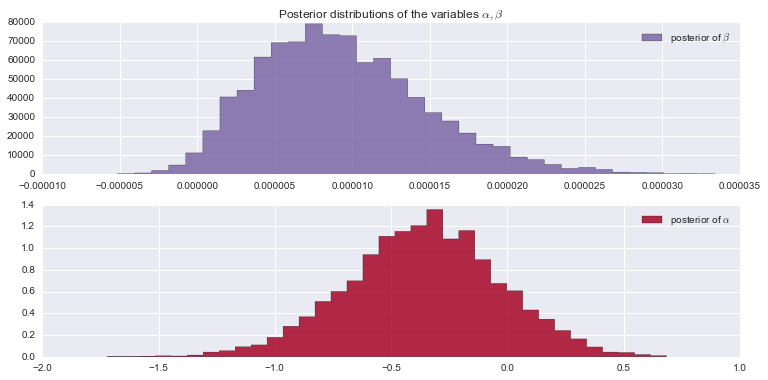

In [146]:
alpha_samples = mcmc.trace('alpha')[:, None]  # best to make them 1d
beta_samples = mcmc.trace('beta')[:, None]

figsize(12.5, 6)

# histogram of the samples:
plt.subplot(211)
plt.title(r"Posterior distributions of the variables $\alpha, \beta$")
plt.hist(beta_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta$", color="#7A68A6", normed=True)
plt.legend()

plt.subplot(212)
plt.hist(alpha_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\alpha$", color="#A60628", normed=True)
plt.legend();

In [147]:
t = np.linspace(temperature.min() - 5, temperature.max() + 5, 50)[:, None]
p_t = logistic(t.T, beta_samples, alpha_samples)

mean_prob_t = p_t.mean(axis=0)

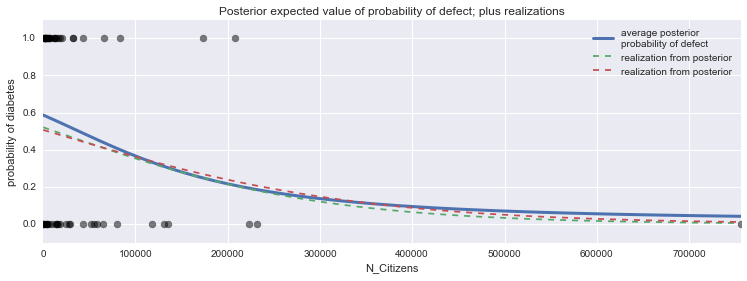

In [153]:
figsize(12.5, 4)

plt.plot(t, mean_prob_t, lw=3, label="average posterior \nprobability \
of defect")
plt.plot(t, p_t[0, :], ls="--", label="realization from posterior")
plt.plot(t, p_t[-2, :], ls="--", label="realization from posterior")
plt.scatter(temperature, D, color="k", s=50, alpha=0.5)
plt.title("Posterior expected value of probability of defect; \
plus realizations")
plt.legend(loc="upper right")
plt.ylim(-0.1, 1.1)
plt.xlim(t.min(), t.max())
plt.ylabel("probability of diabetes")
plt.xlabel("N_Citizens");

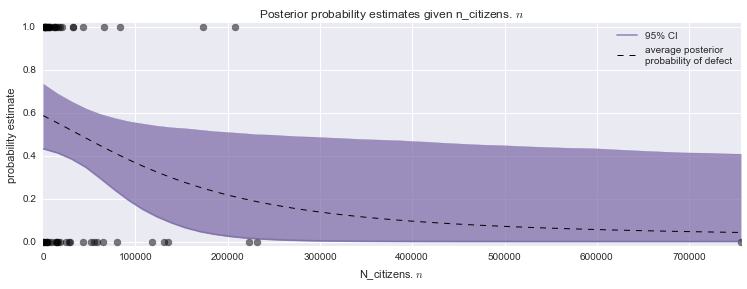

In [157]:
from scipy.stats.mstats import mquantiles

# vectorized bottom and top 2.5% quantiles for "confidence interval"
qs = mquantiles(p_t, [0.025, 0.975], axis=0)
plt.fill_between(t[:, 0], *qs, alpha=0.7,
                 color="#7A68A6")

plt.plot(t[:, 0], qs[0], label="95% CI", color="#7A68A6", alpha=0.7)

plt.plot(t, mean_prob_t, lw=1, ls="--", color="k",
         label="average posterior \nprobability of defect")

plt.xlim(t.min(), t.max())
plt.ylim(-0.02, 1.02)
plt.legend(loc="upper right")
plt.scatter(temperature, D, color="k", s=50, alpha=0.5)
plt.xlabel("N_citizens. $n$")

plt.ylabel("probability estimate")
plt.title("Posterior probability estimates given n_citizens. $n$");

In [185]:
test = [x for x in bayes['POP2010']]

#x for x in df['']

test2 = list(df[df['POP2010'] == test[:]]['County'].values)
d = {}
for i in range(len(test2)):
    d[test2[i]] = test[i]
#test3 = {test2:test}
d

{'Alameda': 1510271,
 'Alpine': 1175,
 'Amador': 38091,
 'Butte': 220000,
 'Calaveras': 45578,
 'Colusa': 21419,
 'Contra Costa': 1049025,
 'Del Norte': 28610,
 'El Dorado': 181058,
 'Fresno': 930450,
 'Glenn': 28122,
 'Humboldt': 134623,
 'Imperial': 174528,
 'Inyo': 18546,
 'Kern': 839631,
 'Kings': 152982,
 'Lake': 64665,
 'Lassen': 34895,
 'Los Angeles': 9818605,
 'Madera': 150865,
 'Marin': 252409,
 'Mariposa': 18251,
 'Mendocino': 87841,
 'Merced': 255793,
 'Modoc': 9686,
 'Mono': 14202,
 'Monterey': 415057,
 'Napa': 136484,
 'Nevada': 98764,
 'Orange': 3010232,
 'Placer': 348432,
 'Plumas': 20007,
 'Riverside': 2189641,
 'Sacramento': 1418788,
 'San Benito': 55269,
 'San Bernardino': 2035210,
 'San Diego': 3095313,
 'San Francisco': 805235,
 'San Joaquin': 685306,
 'San Luis Obispo': 269637,
 'San Mateo': 718451,
 'Santa Barbara': 423895,
 'Santa Clara': 1781642,
 'Santa Cruz': 262382,
 'Shasta': 177223,
 'Sierra': 3240,
 'Siskiyou': 44900,
 'Solano': 413344,
 'Sonoma': 483878,


In [ ]:
for i in d.keys():
    dm= bayes[bayes['POP2010'] == d[i]]['dm']
    prob_county = logistic(dm, beta_samples, alpha_samples)
    plt.xlim(0,1)
    plt.hist(prob_county, histtype='stepfilled', bins=100, normed=True, alpha=0.85)
    plt.title('Probability of {0} Diabetic Citizen living in a Food Desert'.format(i))
    plt.legend()
    plt.show()


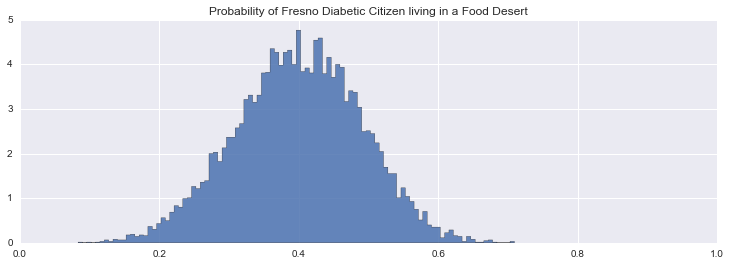

In [194]:
df[df['County'] == 'Fresno']['POP2010']#, 'cnty_dm_pct', 'y', 'dm']]
bayes[bayes['POP2010'] == 930450]
prob_fresno = logistic(83740, beta_samples, alpha_samples)
plt.xlim(0,1)
plt.hist(prob_fresno, histtype='stepfilled', bins=100, normed=True, alpha=0.85)
plt.title('Probability of Fresno Diabetic Citizen living in a Food Desert')
plt.legend()

# plt.subplot(212)
# plt.hist(alpha_samples, histtype='stepfilled', bins=35, alpha=0.85,
#          label=r"posterior of $\alpha$", color="#A60628", normed=True)
# plt.legend();
# #temperature[temperature == 83740]
# #bayes.columns.tolist()

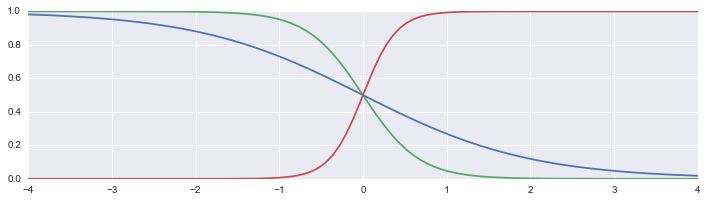

In [136]:
from IPython.core.pylabtools import figsize

figsize(12,3)

def logistic(x,beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta,x)+alpha))

x=np.linspace(-4,4,100)
plt.plot(x, logistic(x,1), label='1')
plt.plot(x,logistic(x,3), label='3')
plt.plot(x,logistic(x,-5), label='-5')


# plt.title('Posterior distributions of $p_DM$(unknown)')
# #plt.vlines(p_true, 0, 90, linestyle='--', title='$p_DM$(unknown)')
# plt.hist(mcmc.trace('p')[:], bins=35, histype='stepfilled',normed=True)
# plt.xlabel("Value of $p_fooddes$")
# plt.ylabel("density")

In [138]:
beta = pm.Normal('beta', 0 , 0.001, value=0)
alpha = pm.Normal('beta', 0 , 0.001, value=0)

@pm.deterministic
def p(pop=bayes['POP2010'], alpha=alpha, beta=beta):
    return 1.0 / (1. + np.exp(beta*t + alpha))

p.value

NameError: global name 't' is not defined

In [115]:

# Bins of how many users clicked 1 time, 2 times, 3 times, ...
bins_A = bayes[bayes['y'] == 1]['dm']#[26912, 58046, 11846, 11295, 5499, 4965, 3266, 2869, 2283, 2062, 1706, 1541, 1348, 1340, 1096, 1062, 890, 849, 845, 734, 659, 584, 586, 570, 537, 554, 505, 502, 439, 421, 437, 378, 342, 389, 356, 333, 317, 298, 348, 296, 328, 287, 314, 269, 289, 260, 252, 256, 15434]
bins_B = bayes[bayes['y'] == 0]['dm']#[26298, 58229, 11656, 11292, 5427, 5073, 3353, 3018, 2319, 2039, 1770, 1581, 1406, 1234, 1096, 1032, 919, 902, 852, 757, 710, 660, 568, 619, 573, 521, 497, 506, 477, 427, 398, 394, 373, 355, 365, 340, 300, 338, 304, 301, 298, 302, 283, 255, 263, 268, 232, 214, 15700]
clicks = range(1, len(bins_A))

# Start with uniform probability over the bins
# p_A = pm.Dirichlet("p_A", theta=np.ones(len(bins_A)))
# p_B = pm.Dirichlet("p_B", theta=np.ones(len(bins_B)))
p_A = pm.Uniform('p_A', lower=0, upper=1)
p_B = pm.Uniform('p_B', lower=0, upper=1)

# A multimodal dist. using the probabilitys of bins
obs_A = pm.Poisson("obs_A", mu=27485.034483, value=bins_A, observed=True)
obs_B = pm.Poisson("obs_B", mu=73722.758621, value=bins_B, observed=True)
['mu', 'value', 'observed', 'size', 'trace', 'rseed', 'doc', 'debug', 'plot', 'verbose']


@pm.deterministic
def percent_better(p_B=p_B, p_A=p_A, clicks=clicks):
    """
    By multiplying each bins probability with 
    what that bin is worth (number of clicks)
    and the summing,
    we get the expected number of clicks (right?).

    We then calculate the lift of B over A in percent
    """
    exp_clicks_B = np.dot(p_B.astype(float)/sum(p_B), clicks)
    exp_clicks_A = np.dot(p_A.astype(float)/sum(p_A), clicks)

    return ((exp_clicks_B / exp_clicks_A) - 1)*100.0

model = pm.Model([p_A, p_B, 
                  obs_A, obs_B, 
                  percent_better])

map_ = pm.MAP(model)
map_.fit() 
mcmc = pm.MCMC(model)
mcmc.sample(120000, burn=20000)

percent_better_samples = mcmc.trace("percent_better")[:]

print "Probability B > A: {}".format((percent_better_samples > 0).mean())
print "Confidence interval of B:s lift over A:"
print np.percentile(percent_better_samples, 2.5)
print np.percentile(percent_better_samples, 97.5)


TypeError: iteration over a 0-d array

In [105]:
import pymc 

def linear_setup(df, ind_cols, dep_col):
    '''
        Inputs: pandas Data Frame, list of strings for the independent variables,
        single string for the dependent variable
        Output: PyMC Model
    '''
    
    # model our intercept and error term as above
    b0 = pymc.Normal("b0", 0, 0.0001)
    err = pymc.Uniform("err", 0, 500)
    
    # initialize a NumPy array to hold our betas 
    # and our observed x values
    b = np.empty(len(ind_cols), dtype=object)
    x = np.empty(len(ind_cols), dtype=object)
    
    # loop through b, and make our ith beta
    # a normal random variable, as in the single variable case
    for i in range(len(b)):
        b[i] = pymc.Normal("b" + str(i + 1), 0, 0.0001)
        
    # loop through x, and inform our model about the observed
    # x values that correspond to the ith position
    for i, col in enumerate(ind_cols):
        x[i] = pymc.Normal("x" + str(i + 1), 0, 1, value=np.array(df[col]), observed=True)
    
    # as above, but use .dot() for 2D array (i.e., matrix) multiplication
    @pymc.deterministic
    def y_pred(b0=b0, b=b, x=x):
        return b0 + b.dot(x)
    
    # finally, "model" our observed y values as above
    y = pymc.Normal("y", y_pred, err, value=np.array(df[dep_col]), observed=True)
    
    return pymc.Model([b0, pymc.Container(b), err, pymc.Container(x), y, y_pred])

test_model = linear_setup(df, ['y','POP2010' ], 'cnty_dm_pct')
mcmc = pymc.MCMC(test_model)
mcmc.sample(100000, 20000)

# def posterior_upvote_ratio(upvotes, downvotes, samples=20000):
#     """
#     This function accepts the number of upvotes and downvotes a particular comment received, 
#     and the number of posterior samples to return to the user. Assumes a uniform prior.
#     """
#     N = upvotes + downvotes
#     upvote_ratio = pm.Uniform("upvote_ratio", 0, 1)
#     observations = pm.Binomial("obs", N, upvote_ratio, value=upvotes, observed=True)
#     # do the fitting; first do a MAP as it is cheap and useful.
#     map_ = pm.MAP([upvote_ratio, observations]).fit()
#     mcmc = pm.MCMC([upvote_ratio, observations])
#     mcmc.sample(samples, samples / 4)
#     return mcmc.trace("upvote_ratio")[:]

# test = posterior_upvote_ratio(des_pop, des_dm, samples=20000)


# y1 = np.array( bayes[bayes['y'] == 1]['dm'].values )
# y2 = np.array( bayes[bayes['y'] == 0]['dm'].values )
# y = pd.DataFrame(dict(value=np.r_[y1, y2], group=np.r_[['des']*len(y1), ['nondes']*len(y2)]))
# y
# y.hist('value', by='group');
# y


/Users/desert/anaconda/lib/python2.7/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 100000 of 100000 complete in 27.5 sec

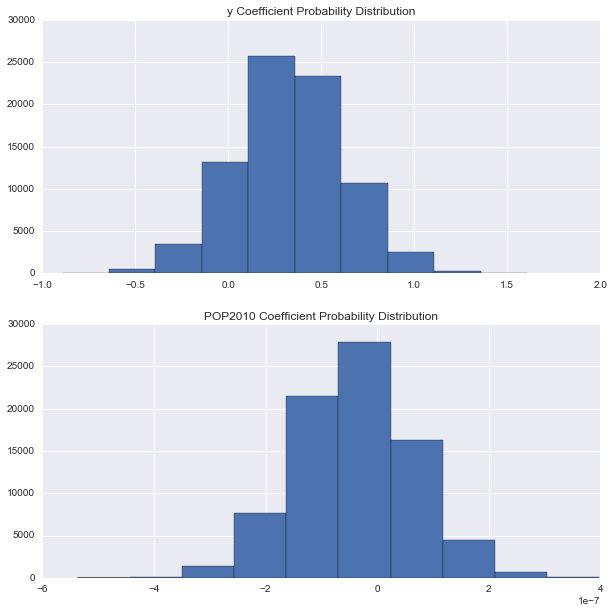

In [106]:
multifig, multiax = plt.subplots(2, 1, figsize=(10, 10))
b_nought = mcmc.trace("b0")[:]
b_y = mcmc.trace("b1")[:]
b_pop = mcmc.trace("b2")[:]

multiax[0].hist(b_y)
multiax[0].set_title("y Coefficient Probability Distribution")
multiax[1].hist(b_pop)
multiax[1].set_title("POP2010 Coefficient Probability Distribution")

In [107]:
print "Intercept: " + str(np.mean(b_nought)) 
print "MD ratio Coefficient: " + str(np.mean(b_y)) 
print "Af_amr Coefficient: " + str(np.mean(b_pop))

Intercept: 7.93729840228
MD ratio Coefficient: 0.331776337163
Af_amr Coefficient: -3.88885588143e-08


The observed diabetes rates are 22.9% and 23.95% for NON_desert counties and desert counties, respectively, but I'd like to be confident that the true diabetes rate of desert counties is higher than NON_desert counties.

To format this data for the analysis, I create a numpy array for each group with 1s representing diabetics and 0s representing nondiabetic citizens:

In [73]:
data_A = np.r_[[0] * (non_des_pop - non_des_dm), [1] * non_des_dm]
data_B = np.r_[[0] * (des_pop - des_dm), [1] * des_dm]

Next I assign distributions to my prior beliefs of p_A and p_B, the unknown, true diabetes rates. I assume, for simplicity, that the distributions are uniform (i.e. I have no prior knowledge of what p_A and 'p_B' are). 

In [74]:
import pymc as pm

p_A = pm.Uniform('p_A', lower=0, upper=1)
p_B = pm.Uniform('p_B', lower=0, upper=1)

Since I want to estimate the difference in true diabetes rates, I need to define a variable delta, which equals p_B - p_A. Since, if I know both p_A and p_B, I can calculate delta, it's a deterministic variable. In PyMC, deterministic variables are created using a function with a pymc.deterministic wrapper:

In [75]:
@pm.deterministic
def delta(p_A=p_A, p_B=p_B):
    return p_B - p_A

Next I add the observed data to PyMC variables and run an inference algorithm

In [76]:
obs_A = pm.Bernoulli("obs_A", p_A, value = data_A, observed = True)
obs_B = pm.Bernoulli("obs_B", p_B, value = data_B, observed = True)


In [77]:
# #plt.hist(data_B)
# # Generate some random normal data
# group1 = bayes[bayes['y'] == 1]['dm'].values 
# group2 = bayes[bayes['y'] == 0]['dm'].values

# # Generate Pooled Data
# pooled = np.concatenate((group1,group2)) 

# #plt.hist(bayes['dm'])
# #sns.distplot(bayes[bayes['y'] == 1]['dm']) # Poisson
# #sns.distplot(bayes[bayes['y'] == 0]['dm'])# Poisson

# # Setup our priors
# mu1 = pm.Poisson("mu_1",mu=pooled.mean(), tau=1.0/pooled.var()/len(pooled))  
# mu2 = pm.Poisson("mu_2",mu=pooled.mean(), tau=1.0/pooled.var()/len(pooled))
# mu2
# # sig1 = pm.Uniform("sigma_1",lower=pooled.var()/1000.0,upper=pooled.var()*1000)  
# # sig2 = pm.Uniform("sigma_2",lower=pooled.var()/1000.0,upper=pooled.var()*1000)

# # v = pm.Exponential("nu",beta=1.0/29) 

In [86]:
data_A
print 'Probability NON Food desert resident being diabetic = %.0f%%', (np.mean(data_A) * 100)
print 'Probability Food desert resident being diabetic = %.0f%%', (np.mean(data_B) * 100)

Probability NON Food desert resident being diabetic = %.0f%% 7.67385850116
Probability Food desert resident being diabetic = %.0f%% 22.7596156385


In [88]:

def run_exp():
    # Generate 50 random binary variables with probability = 0.5
    test_a = stats.bernoulli(.5).rvs(50)
    test_b = stats.bernoulli(.5).rvs(50)

    for i in range(2, 50):
        # Run statistical t-test
        _, p = stats.ttest_ind(test_a[:i], test_b[:i])
        if p < 0.05:
            return True
        
    return False

p_sign_result = np.mean([run_exp() for i in range(1000)])

print 'Probability of getting significant result even though no\n difference exists = %.2f%%' % (p_sign_result * 100)

Probability of getting significant result even though no
 difference exists = 36.00%


Then I plot the posterior distributions for the three unknowns:

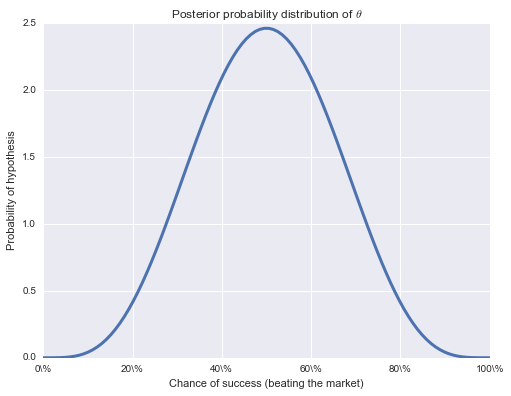

In [90]:
def gen_plot(success=(0, 100), failure=(0, 100)):
    alpha = 5 + success
    beta = 5 + success
    fig = plt.figure(figsize=(8, 6))
    x = np.linspace(0, 1, 100)
    ax = fig.add_subplot(111, xlabel='Chance of success (beating the market)', 
                         ylabel='Probability of hypothesis', 
                         title=r'Posterior probability distribution of $\theta$')
    ax.plot(x, stats.beta(alpha, beta).pdf(x), linewidth=3.)
    ax.set_xticklabels(['0\%', '20\%', '40\%', '60\%', '80\%', '100\%']);
    
gen_plot(0, 0)

In [93]:
algo_a = stats.bernoulli(.5).rvs(300) # 50% profitable days
algo_b = stats.bernoulli(.6).rvs(300) # 60% profitable days
algo_a

array([1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1])

In [94]:

import pymc as pm
model = pm.Model()
with model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define random variables
    theta_a = pm.Beta('theta_a', alpha=5, beta=5) # prior
    theta_b = pm.Beta('theta_b', alpha=5, beta=5) # prior
    
    # Define how data relates to unknown causes
    data_a = pm.Bernoulli('observed A',
                          p=theta_a, 
                          observed=algo_a)
    
    data_b = pm.Bernoulli('observed B', 
                          p=theta_b, 
                          observed=algo_b)
    
    # Inference!
    start = pm.find_MAP() # Find good starting point
    step = pm.Slice() # Instantiate MCMC sampling algorithm
    trace = pm.sample(10000, step, start=start, progressbar=False) # draw posterior samples using slice sampling 

AttributeError: __exit__

In [ ]:
p_A_samples = mcmc.trace("p_A")[:]
p_B_samples = mcmc.trace("p_B")[:]
delta_samples = mcmc.trace("delta")[:]

ax = plt.subplot(311)

plt.xlim(0, .035)
plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
label="posterior of $p_A$", color="#A60628", normed=True,
edgecolor= "none")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta
unknowns")

ax = plt.subplot(312)

plt.xlim(0, .035)
plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
        label="posterior of $p_B$", color="#467821", normed=True,
        edgecolor = "none")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.ylim(0,120)
plt.hist(delta_samples, histtype='stepfilled', bins=50, alpha=0.85,
        label="posterior of $p_B$ - $p_A$", color="#7A68A6",normed=True,
        edgecolor = "none")
plt.legend(loc="upper right")
plt.vlines(0, 0, 120, color="black", alpha = .5)

plt.show()

I can also compute the probability that the true diabetes rate of non desert counties, p_A, is better than the true diabetes rate of desert counties, p_B:

In [ ]:
print "Probability NON-desert counties is BETTER than desert counties: %.3f" %
(delta_samples < 0).mean()
print "Probability NON-desert counties is WORSE than desert counties: %.3f" %
(delta_samples > 0).mean()

Frequenist Approach Linear Regression
----

1. Standardize variables (not doing so will cause us to mistake covariation for correlation)
     a measure of association that is affected by the scale of the variables 
2. 

In [ ]:
def covariance(variable_1, variable_2, bias=0):
    observations = float(len(variable_1))
    return np.sum((variable_1 - np.mean(variable_1)) * (variable_2 - np.mean(variable_2)))/(observations-min(bias,1))

def standardize(variable):
    return (variable - np.mean(variable)) / np.std(variable)

def correlation(var1,var2,bias=0):
    return covariance(standardize(var1), standardize(var2),bias)

# calculating r2 manually
mean_sum_squared_errors = np.sum((dataset['target']-dataset['target'].mean())**2)
regr_sum_squared_errors = np.sum((dataset['target']-fitted_values)**2)
r2 = (mean_sum_squared_errors-regr_sum_squared_errors) / mean_sum_squared_errors

# calculating r2 with scipy
(pearsonr(x_var, y_var)[0])**2

In [ ]:
stats.ttest_ind(df['percent_food_desert'], df['n_food_des'])  

The problem with this approach is that it forgets that there are links between observations: percent_food_desert and n_food_des are measured on the same counties. Thus the variance due to inter-subject variability is confounding, and can be removed, using a “paired test”, or “repeated measures test”:

In [ ]:
stats.ttest_rel(df['percent_food_desert'], df['n_food_des']) 
#This is equivalent to a 1-sample test on the difference:
#stats.ttest_1samp(df['percent_food_desert'] - df['n_food_des'], 0)   


T-tests assume Gaussian errors. We can use a Wilcoxon signed-rank test, that relaxes this assumption:

In [ ]:
stats.wilcoxon(df['percent_food_desert'], df['n_food_des']) 

Conclusion: we find that the data does support the hypothesis that counties with greater than 10% of the population living in a food desert and counties with less than 10% of the population living in a food desert have different consumptions of prescription opiods.

In [ ]:
model = smf.ols('percent_food_desert ~ opiods_rx_1000 + Urban', df).fit()
model.summary()

In [ ]:
sns.pairplot(df, vars=['percent_food_desert', 'opiods_rx_1000', 'ABR', 'Rural'],kind='reg', hue='y')  

In [ ]:

stats.ttest_1samp(des_mean, not_des_mean)
stats.shapiro(des['opiods_rx_1000'])
stats.shapiro(not_des['opiods_rx_1000'])

In [ ]:
import pymc

In [ ]:
# Website A had 1055 clicks and 28 sign-ups
values_A = np.hstack(([0]*(des['pop2010_in_des'].values-des['opiods_rx_1000'].values),[1]*(des['opiods_rx_1000'].values)))
# Website B had 1057 clicks and 45 sign-ups
values_B = np.hstack(([0]*(1057-45),[1]*45))
des[['pop2010_in_des','opiods_rx_1000']]
values_A

In [ ]:
def corrcoeff(frame1,var1,var2):
    frame = frame1.copy()
    frame['corrn']=(frame[var1]-np.mean(frame[var1]))*(frame[var2]-np.mean(frame[var2]))
    frame['corrd1']=(frame[var1]-np.mean(frame[var1]))**2
    frame['corrd2']=(frame[var2]-np.mean(frame[var2]))**2
    corrcoeffn=frame.sum()['corrn']
    corrcoeffd1=frame.sum()['corrd1']
    corrcoeffd2=frame.sum()['corrd2']
    corrcoeffd=np.sqrt(corrcoeffd1*corrcoeffd2)
    corrcoeff=corrcoeffn/corrcoeffd
    return corrcoeff

corrcoeff(df,'percent_food_desert','Urban')
corrcoeff(df,'percent_food_desert','Rural')

In [ ]:
plt.plot(df['Rural'],df['percent_food_desert'],'ro')
plt.title('Urban vs percent_food_desert')